dataset source: https://www.kaggle.com/datasets/andy8744/ganyu-genshin-impact-anime-faces-gan-training?resource=download-directory

In [3]:
import tensorflow as tf
import tensorflow.keras.utils
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

from  matplotlib import pyplot as plt
import os
import cv2
%matplotlib inline


In [3]:
print('tensorflow: %s' % tensorflow.__version__)

tensorflow: 2.8.0


In [4]:
tf.keras.backend.clear_session()

In [7]:
train_path = r'F:\DCGAN Ganyu\ganyu-final'

latent_dim = 4096
alpha = 0.2 

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode=None,
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
)

train_ds = train_ds.map(lambda x: x / 255.0)

Found 850 files belonging to 1 classes.


In [7]:
discriminator = Sequential(
    [
        keras.Input(shape=(256, 256, 3), name='discriminator_input'),
        
        #256x256x3
        layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'),
        layers.LeakyReLU(alpha),
        layers.AveragePooling2D(),
        
        #128x128x8
        layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8), #default momentum = 0.99
        layers.LeakyReLU(alpha),
        layers.AveragePooling2D(),
        
        #64x64x16
        layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.LeakyReLU(alpha),
        layers.Dropout(0.25),
        layers.AveragePooling2D(),
        
        #32x32x32
        layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.LeakyReLU(alpha),
        layers.AveragePooling2D(),
        
        #16x16x64
        layers.Conv2D(filters = 128, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.LeakyReLU(alpha),
        layers.AveragePooling2D(),
        
        #8x8x128
        layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.LeakyReLU(alpha),
        layers.AveragePooling2D(),
        
        #4x4x256
        layers.Flatten(),
        
        #256
        layers.Dense(128),
        layers.LeakyReLU(alpha),
        
        layers.Dense(1, activation = 'sigmoid'),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)       0         
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 8)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 16)    

In [8]:
generator = Sequential(
    [
        
        layers.Reshape(target_shape = [1, 1, 4096], input_shape = [4096]),
        
        #1x1x4096 
        layers.Conv2DTranspose(filters = 256, kernel_size = 4),
        layers.Activation('relu'),
        
        #4x4x256
        layers.Conv2D(filters = 256, kernel_size = 4, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8), #default momentum = 0.99
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #8x8x256
        layers.Conv2D(filters = 128, kernel_size = 4, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #16x16x128
        layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #32x32x64
        layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #64x64x32
        layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same'),
        layers.BatchNormalization(momentum = 0.8),
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #128x128x16
        layers.Conv2D(filters = 8, kernel_size = 3, padding = 'same'),
        layers.Activation('relu'),
        layers.UpSampling2D(),
        
        #256x256x8
        layers.Conv2D(filters = 3, kernel_size = 3, padding = 'same'),
        layers.Activation('sigmoid'),
        
         ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 4096)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        16777472  
 nspose)                                                         
                                                                 
 activation (Activation)     (None, 4, 4, 256)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         1048832   
                                                                 
 batch_normalization_5 (Batc  (None, 4, 4, 256)        1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 4, 4, 256)         0 

In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
        
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.g_loss_metric = keras.metrics.Mean(name="generator_loss")
        self.d_loss_metric = keras.metrics.Mean(name="discriminator_loss")
        
   

    def train_step(self, real_images):
        
    
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "g_loss": self.g_loss_metric.result(),
            "d_loss": self.d_loss_metric.result(),
        }

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=4096):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("epoch_%03d_nr_%d.jpg" % (epoch, i))
            plt.show()

In [11]:
epochs = 1000

gan = GAN(discriminator=discriminator, 
          generator=generator, 
          latent_dim=latent_dim)


gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


gan.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/1000
27/27 [==============================] - 12s 121ms/step - g_loss: 0.6891 - d_loss: 0.6731
Epoch 2/1000
27/27 [==============================] - 2s 85ms/step - g_loss: 0.8735 - d_loss: 0.6141
Epoch 3/1000
27/27 [==============================] - 2s 84ms/step - g_loss: 1.1282 - d_loss: 0.6104
Epoch 4/1000
27/27 [==============================] - 2s 84ms/step - g_loss: 0.8363 - d_loss: 0.7053
Epoch 5/1000
27/27 [==============================] - 2s 84ms/step - g_loss: 1.9923 - d_loss: 0.6136
Epoch 6/1000
27/27 [==============================] - 2s 85ms/step - g_loss: 1.1221 - d_loss: 0.6220
Epoch 7/1000
27/27 [==============================] - 2s 87ms/step - g_loss: 1.1738 - d_loss: 0.5980
Epoch 8/1000
27/27 [==============================] - 2s 84ms/step - g_loss: 1.1889 - d_loss: 0.5654
Epoch 9/1000
27/27 [==============================] - 2s 84ms/step - g_loss: 1.3345 - d_loss: 0.5024
Epoch 10/1000
27/27 [==============================] - 2s 85ms/step - g_loss: 1.2786 - d_

In [8]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
  
    images = images[:20]
    plt.figure(figsize=(20,20))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

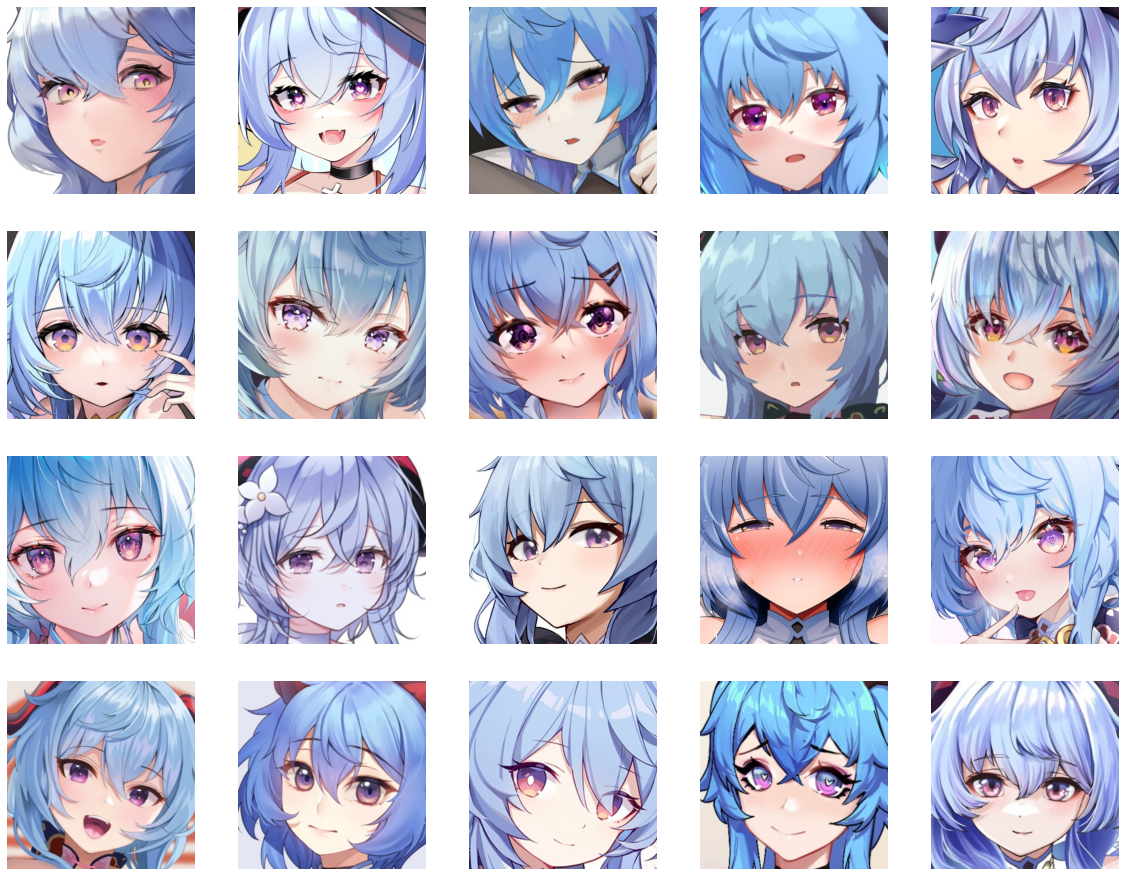

In [9]:
load_images_from_folder(train_path)

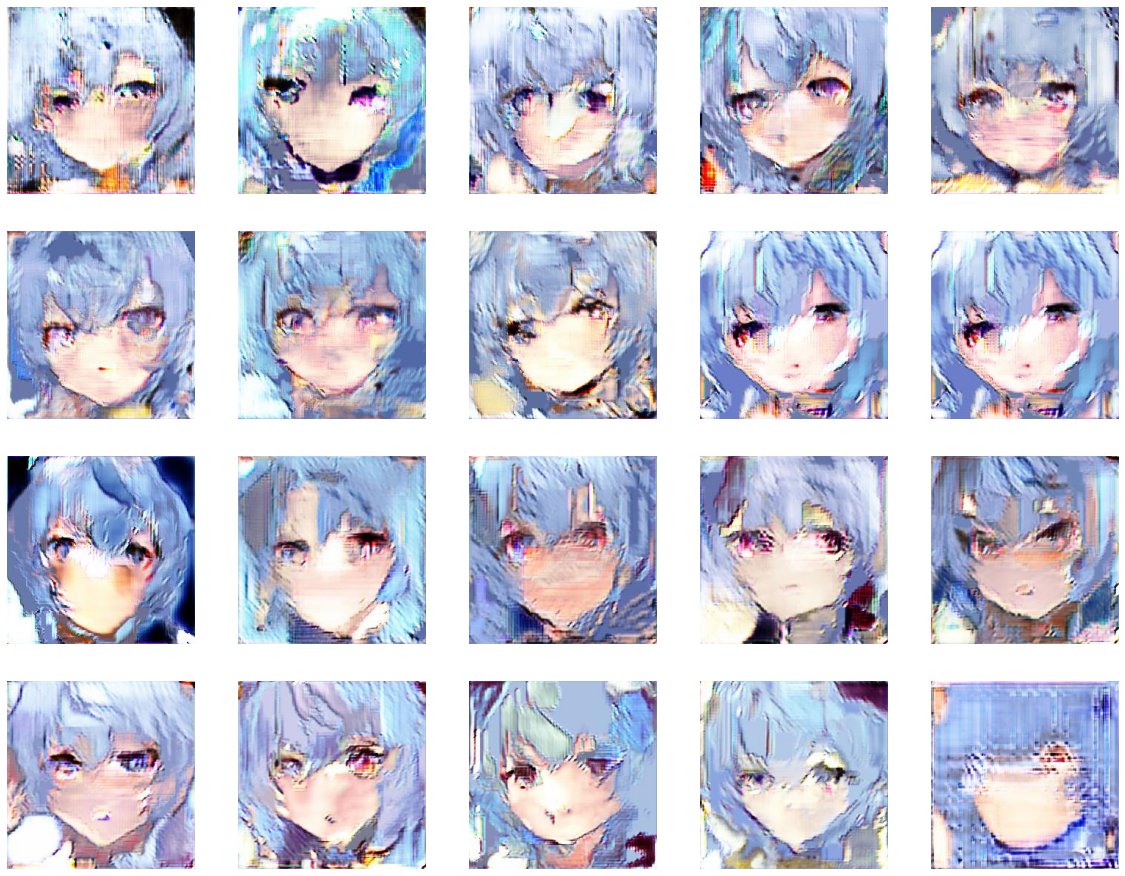

In [10]:
load_images_from_folder(r"F:\DCGAN Ganyu\some good output")